# Mount Google Drive

In [11]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130812 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [13]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

# Manipulate Midi files

In [0]:
import mido
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import colorConverter


# inherit the origin mido class
class MidiFile(mido.MidiFile):

    def __init__(self, filename):

        mido.MidiFile.__init__(self, filename)
        self.sr = 10
        self.meta = {}
        self.events = self.get_events()

    def get_events(self):
        mid = self
        print(mid)

        # There is > 16 channel in midi.tracks. However there is only 16 channel related to "music" events.
        # We store music events of 16 channel in the list "events" with form [[ch1],[ch2]....[ch16]]
        # Lyrics and meta data used a extra channel which is not include in "events"

        events = [[] for x in range(16)]

        # Iterate all event in the midi and extract to 16 channel form
        for track in mid.tracks:
            for msg in track:
                try:
                    channel = msg.channel
                    events[channel].append(msg)
                except AttributeError:
                    try:
                        if type(msg) != type(mido.UnknownMetaMessage):
                            self.meta[msg.type] = msg.dict()
                        else:
                            pass
                    except:
                        print("error",type(msg))

        return events

    def get_roll(self):
        events = self.get_events()
        # Identify events, then translate to piano roll
        # choose a sample ratio(sr) to down-sample through time axis
        sr = self.sr

        # compute total length in tick unit
        length = self.get_total_ticks()

        # allocate memory to numpy array
        roll = np.zeros((16, 128, length // sr), dtype="int8")

        # use a register array to save the state(no/off) for each key
        note_register = [int(-1) for x in range(128)]

        # use a register array to save the state(program_change) for each channel
        timbre_register = [1 for x in range(16)]


        for idx, channel in enumerate(events):

            time_counter = 0
            volume = 100
            # Volume would change by control change event (cc) cc7 & cc11
            # Volume 0-100 is mapped to 0-127

            print("channel", idx, "start")
            for msg in channel:
                if msg.type == "control_change":
                    if msg.control == 7:
                        volume = msg.value
                        # directly assign volume
                    if msg.control == 11:
                        volume = volume * msg.value // 127
                        # change volume by percentage
                    # print("cc", msg.control, msg.value, "duration", msg.time)

                if msg.type == "program_change":
                    timbre_register[idx] = msg.program
                    print("channel", idx, "pc", msg.program, "time", time_counter, "duration", msg.time)



                if msg.type == "note_on":
                    #print("on ", msg.note, "time", time_counter, "duration", msg.time, "velocity", msg.velocity)
                    note_on_start_time = time_counter // sr
                    note_on_end_time = (time_counter + msg.time) // sr
                    intensity = volume * msg.velocity // 127



          # When a note_on event *ends* the note start to be play 
          # Record end time of note_on event if there is no value in register
          # When note_off event happens, we fill in the color
                    if note_register[msg.note] == -1:
                        note_register[msg.note] = (note_on_end_time,intensity)
                    else:
          # When note_on event happens again, we also fill in the color
                        old_end_time = note_register[msg.note][0]
                        old_intensity = note_register[msg.note][1]
                        roll[idx, msg.note, old_end_time: note_on_end_time] = old_intensity
                        note_register[msg.note] = (note_on_end_time,intensity)


                if msg.type == "note_off":
                    print("off", msg.note, "time", time_counter, "duration", msg.time, "velocity", msg.velocity)
                    note_off_start_time = time_counter // sr
                    note_off_end_time = (time_counter + msg.time) // sr
                    note_on_end_time = note_register[msg.note][0]
                    intensity = note_register[msg.note][1]
          # fill in color
                    roll[idx, msg.note, note_on_end_time:note_off_end_time] = intensity

                    note_register[msg.note] = -1  # reinitialize register

                time_counter += msg.time

                # TODO : velocity -> done, but not verified
                # TODO: Pitch wheel
                # TODO: Channel - > Program Changed / Timbre catagory
                # TODO: real time scale of roll

            # if there is a note not closed at the end of a channel, close it
            for key, data in enumerate(note_register):
                if data != -1:
                    note_on_end_time = data[0]
                    intensity = data[1]
                    # print(key, note_on_end_time)
                    note_off_start_time = time_counter // sr
                    roll[idx, key, note_on_end_time:] = intensity
                note_register[idx] = -1

        return roll

    def get_roll_image(self):
        roll = self.get_roll()
        plt.ioff()

        K = 16

        transparent = colorConverter.to_rgba('black')
        colors = [mpl.colors.to_rgba(mpl.colors.hsv_to_rgb((i / K, 1, 1)), alpha=1) for i in range(K)]
        cmaps = [mpl.colors.LinearSegmentedColormap.from_list('my_cmap', [transparent, colors[i]], 128) for i in
                 range(K)]

        for i in range(K):
            cmaps[i]._init()  # create the _lut array, with rgba values
            # create your alpha array and fill the colormap with them.
            # here it is progressive, but you can create whathever you want
            alphas = np.linspace(0, 1, cmaps[i].N + 3)
            cmaps[i]._lut[:, -1] = alphas

        fig = plt.figure(figsize=(4, 3))
        a1 = fig.add_subplot(111)
        a1.axis("equal")
        a1.set_facecolor("white")

        array = []

        for i in range(K):
            try:
                img = a1.imshow(roll[i], interpolation='nearest', cmap=cmaps[i], aspect='auto')
                array.append(img.get_array())
            except IndexError:
                pass
        return array

    def draw_roll(self):


        roll = self.get_roll()

        # build and set fig obj
        #plt.ioff()
        fig = plt.figure(figsize=(15, 3))
        a1 = fig.add_subplot(111)
        a1.axis("equal")
        a1.set_facecolor("white")

        # change unit of time axis from tick to second
        tick = self.get_total_ticks()
        second = mido.tick2second(tick, self.ticks_per_beat, self.get_tempo())
        print(second)
        if second > 10:
            x_label_period_sec = second // 10
        else:
            x_label_period_sec = second / 10  # ms
        print(x_label_period_sec)
        x_label_interval = mido.second2tick(x_label_period_sec, self.ticks_per_beat, self.get_tempo()) / self.sr
        print(x_label_interval)
        #plt.xticks([int(x * x_label_interval) for x in range(20)], [round(x * x_label_period_sec, 2) for x in range(20)])
        plt.xticks([])
        plt.yticks([])
        
        # change scale and label of y axis
        #plt.yticks([y*16 for y in range(8)], [y*16 for y in range(8)])

        # build colors
        channel_nb = 16
        transparent = colorConverter.to_rgba('black')
        colors = [mpl.colors.to_rgba(mpl.colors.hsv_to_rgb((i / channel_nb, 1, 1)), alpha=1) for i in range(channel_nb)]
        cmaps = [mpl.colors.LinearSegmentedColormap.from_list('my_cmap', [transparent, colors[i]], 128) for i in
                 range(channel_nb)]

        # build color maps
        for i in range(channel_nb):
            cmaps[i]._init()
            # create your alpha array and fill the colormap with them.
            alphas = np.linspace(0, 1, cmaps[i].N + 3)
            # create the _lut array, with rgba values
            cmaps[i]._lut[:, -1] = alphas


        # draw piano roll and stack image on a1
        for i in range(channel_nb):
            try:
                a1.imshow(roll[i], origin="lower", interpolation='nearest', cmap=cmaps[i], aspect='auto')
            except IndexError:
                pass

        # draw color bar

        colors = [mpl.colors.hsv_to_rgb((i / channel_nb, 1, 1)) for i in range(channel_nb)]
        cmap = mpl.colors.LinearSegmentedColormap.from_list('my_cmap', colors, 16)
        #a2 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
        #cbar = mpl.colorbar.ColorbarBase(a2, cmap=cmap,
                                        #orientation='horizontal',
                                        #ticks=list(range(16)))

        # show piano roll
        plt.draw()
        plt.savefig('temp.png',bbox_inches="tight", pad_inches=0)
        plt.ion()
        plt.show(block=True)

    def get_tempo(self):
        try:
            return self.meta["set_tempo"]["tempo"]
        except:
            return 500000

    def get_total_ticks(self):
        max_ticks = 0
        for channel in range(16):
            ticks = sum(msg.time for msg in self.events[channel])
            if ticks > max_ticks:
                max_ticks = ticks
        return max_ticks


Channel -  0


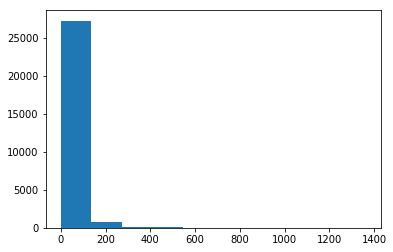

Channel -  1


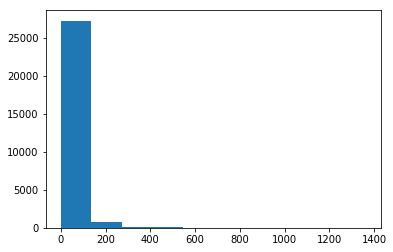

Channel -  2


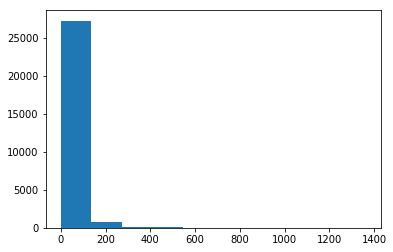

Channel -  3


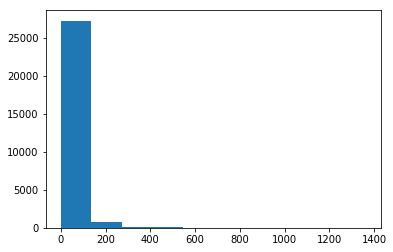

Channel -  4


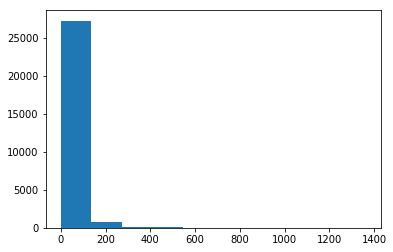

Channel -  5


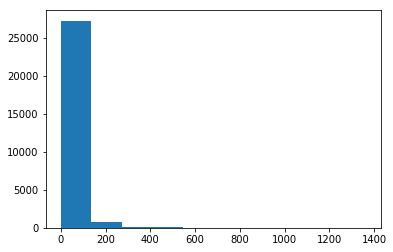

Channel -  6


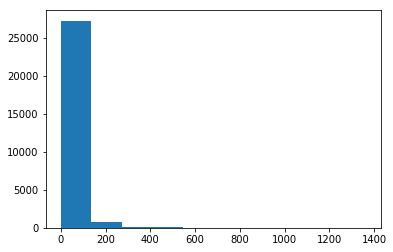

Channel -  7


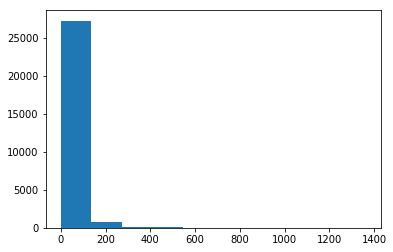

Channel -  8


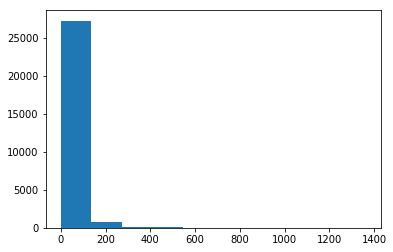

Channel -  9


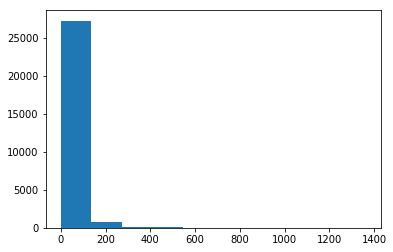

Channel -  10


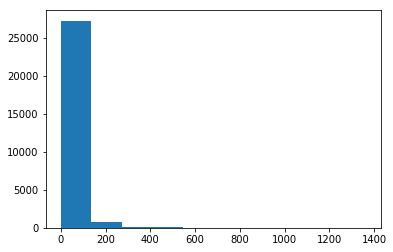

Channel -  11


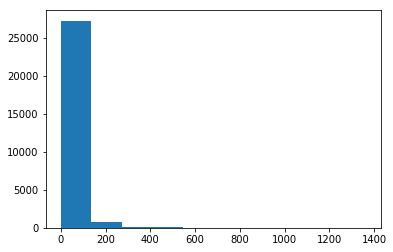

Channel -  12


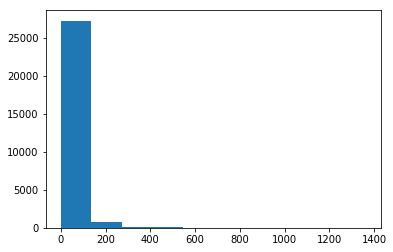

Channel -  13


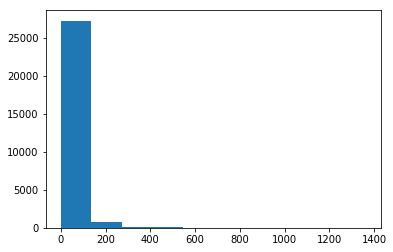

Channel -  14


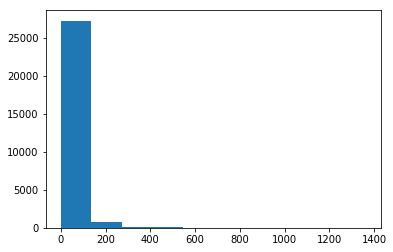

Channel -  15


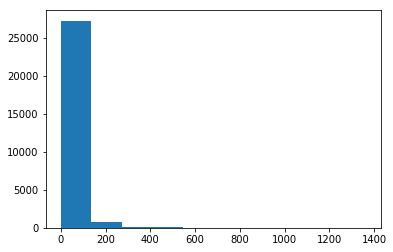

In [42]:
times = []
for channel in range(16):
  for event in mid.events[channel]:
    times.append(event.time)
  print("Channel - ",channel)
  plt.hist(times)
  plt.show()

<midi file 'drive/Deep Learning Project/maestro-v1.0.0/2004/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.midi' type 1, 2 tracks, 28245 messages>
<midi file 'drive/Deep Learning Project/maestro-v1.0.0/2004/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.midi' type 1, 2 tracks, 28245 messages>
channel 0 start
channel 0 pc 0 time 0 duration 0
channel 1 start
channel 2 start
channel 3 start
channel 4 start
channel 5 start
channel 6 start
channel 7 start
channel 8 start
channel 9 start
channel 10 start
channel 11 start
channel 12 start
channel 13 start
channel 14 start
channel 15 start
970.5124999999999
97.0
9312.0


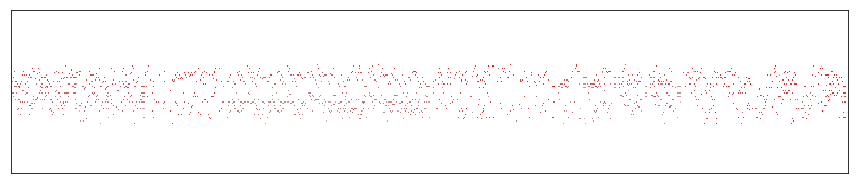

In [40]:
  mid = MidiFile("drive/Deep Learning Project/maestro-v1.0.0/2004/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.midi")

  
  # get the list of all events
  # events = mid.get_events()

  # get the np array of piano roll image
  #roll = mid.get_roll()

  # draw piano roll by pyplot
  mid.draw_roll()

In [41]:
import imageio

im = imageio.imread('temp.png')
print(im.shape)

(170, 844, 4)
